In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from reader import OldReader
import matplotlib.patches as patches

First, load the Stanford puffer data. Make sure that you've ran `./download_data.sh` first. This may take a few minutes to process.

Then, we will process and reformat the data in a way that makes plotting it easier.

In [2]:
reader = OldReader("./data/real_052425/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)


    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","timestamp"], how="left")
    return df_sent, df_acked, df_buf, group_df

df_sent, df_acked, df_buf, group_df = analyze(reader)

             timestamp                                    session_id index  \
0  1748002167625000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
1  1748002167665000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
2  1748002167704000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
3  1748002167740000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   
4  1748002167790000000  z4e5qmKUImHc/kbUas+xa/pQjPRFhZhthEIBz92VDsg=     6   

  expt_id channel      video_ts       format    size ssim_index cwnd  \
0    2216     abc  127948700880  1280x720-20  402111   0.984716  784   
1    2216     abc  127948881060  1280x720-20  382769   0.984888  662   
2    2216     abc  127949061240  1280x720-20  393072    0.98451  662   
3    2216     abc  127949241420  1280x720-20  635186   0.985032  684   
4    2216     abc  127949421600  1280x720-20  507943    0.98557  732   

  in_flight min_rtt    rtt delivery_rate  
0         0   16161  17534      12870822  
1         0 

In [3]:
group_keys = ["expt_id", "session_id"]
group_df["ssim_index"] = group_df["ssim_index"].astype(np.float64)
group_df["delivery_rate"] = group_df["delivery_rate"].astype(np.float64)
group_df["rtt"] = group_df["rtt"].astype(np.float64)
group_df["qual_throughput"] = pd.qcut(group_df["rtt"].astype(np.float64), 3, labels=["low","medium","high"])
group_df["qual_rtt"] = pd.qcut(group_df["rtt"].astype(np.float64), 3, labels=["low","medium","high"])
grouped_group = group_df.groupby(group_keys)


In [4]:
time_s = (grouped_group["timestamp"].max() - grouped_group["timestamp"].min()).apply(lambda x: float(x) / 1000000000.0)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
ssim = grouped_group["ssim_index"].mean()

graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel_x"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                         "qual_latency": grouped_group["qual_rtt"].min()
                        }).merge(ssim, how="inner", on=["expt_id", "session_id"])


In [5]:
# map the integer expt_id to a text version
import json

name_lookup = {}
expt_lookup_f = "./data/real_052425/logs/expt_settings"
with open(expt_lookup_f, "r") as f:
    for line in f:
        words = line.split(" ")
        exp_id = int(words[0])
        json_s = " ".join(words[1:])
        j_obj = json.loads(json_s)
        try:
            if j_obj["abr"] == "puffer_ttp":
                name_lookup[exp_id] = j_obj["abr_name"]
            else:
                name_lookup[exp_id] = j_obj["abr"]
        except KeyError as e:
            continue



In [6]:
graph_df = graph_df.reset_index()
graph_df["expt_id"] = graph_df["expt_id"].apply(lambda x: name_lookup[int(x)])

# Comparison of many ABR algorithms on Puffer's data

Now, we're going to plot a few overall comparisons of the QoE distribution (measured in terms of video quality (SSIM) and rebuffering) to get an initial sense of the data.

Then, we'll break down the data and plots to do a more-detailed analysis.

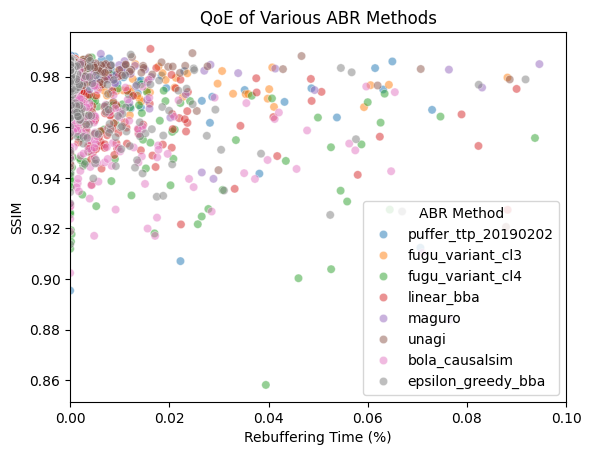

In [10]:
ax = sns.scatterplot(graph_df, x="rebuf",y="ssim_index", hue="expt_id", alpha=0.5)
ax.set_xlim([0.0,0.1])
ax.set_xlabel("Rebuffering Time (%)")
ax.set_ylabel("SSIM")
plt.title("QoE of Various ABR Methods")
ax.legend(title="ABR Method")
plt.show()

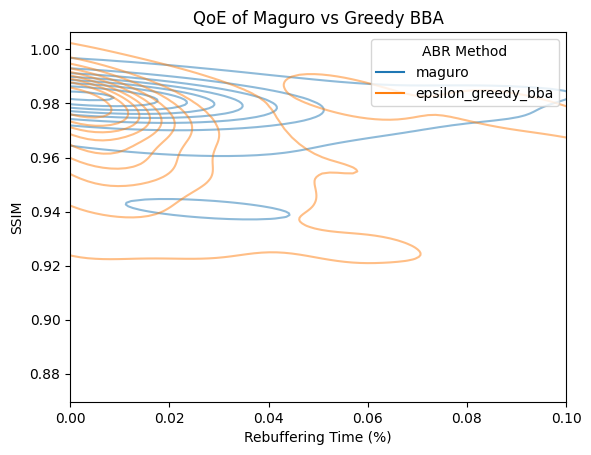

In [26]:
fig, ax = plt.subplots()
ax.set_xlim([0.0,0.1])
filt_graph = graph_df[(graph_df["expt_id"] == "epsilon_greedy_bba") | (graph_df["expt_id"] == "maguro")]
sns.kdeplot(filt_graph, x="rebuf",y="ssim_index", hue="expt_id", alpha=0.5, ax=ax)
ax.set_xlabel("Rebuffering Time (%)")
ax.set_ylabel("SSIM")
plt.title("QoE of Maguro vs Greedy BBA")
leg = ax.get_legend()
leg.set_title("ABR Method")
plt.show()

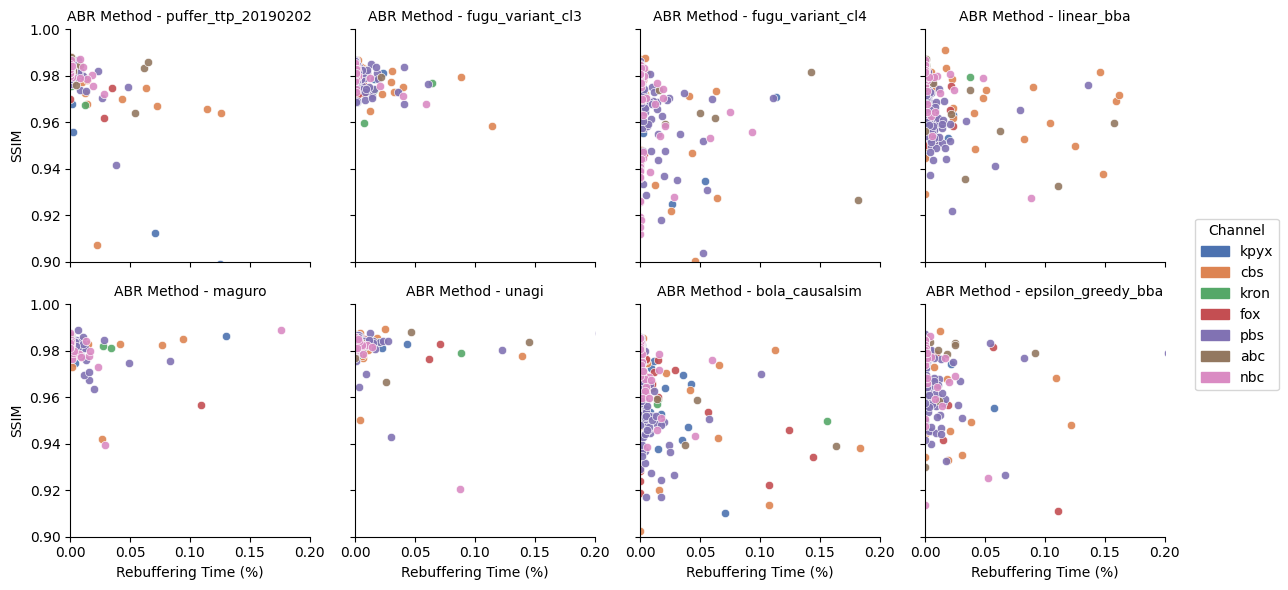

In [34]:
import matplotlib.patches as patches
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4, xlim=(0,0.2), ylim=(0.9,1.0))
grid.set_titles("ABR Method - {col_name}")
#grid.set_axis_labels(x_var="Rebuffering Time (%)", y_var="SSIM")
grid.map(sns.scatterplot,"rebuf","ssim_index",alpha=0.9)
grid.set_xlabels("Rebuffering Time (%)")
grid.set_ylabels("SSIM")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='Channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

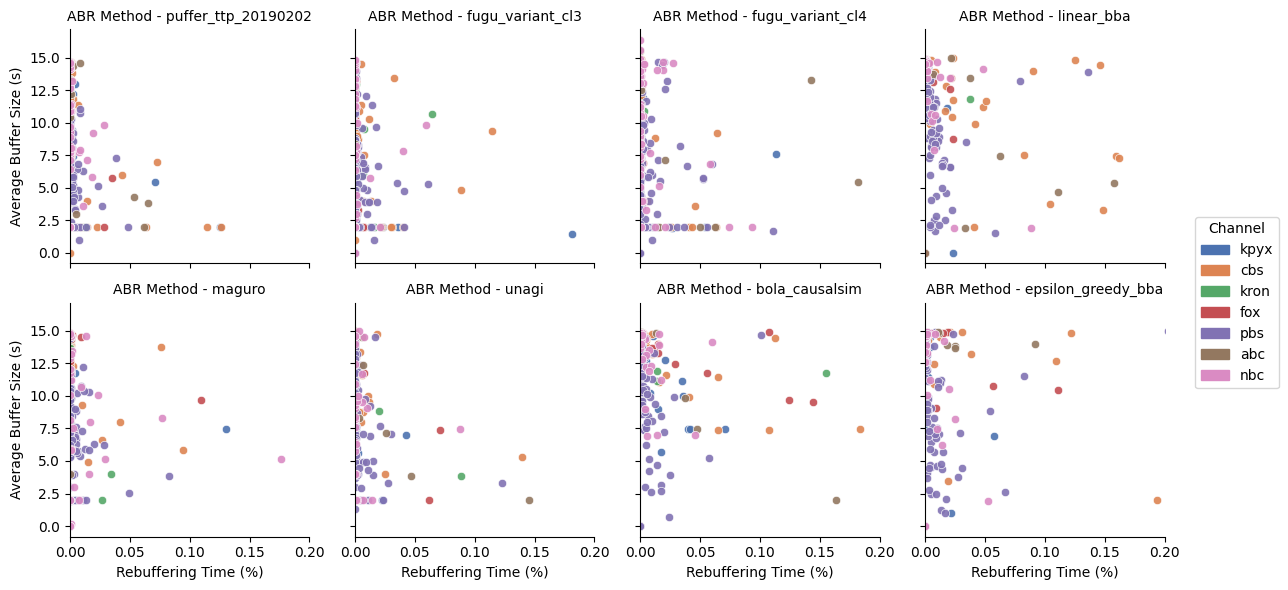

In [36]:
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2))
grid.set_titles("ABR Method - {col_name}")
grid.map(sns.scatterplot,"rebuf","avg_buffer",alpha=0.9)
grid.set_axis_labels(x_var="Rebuffering Time (%)", y_var="Average Buffer Size (s)")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='Channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

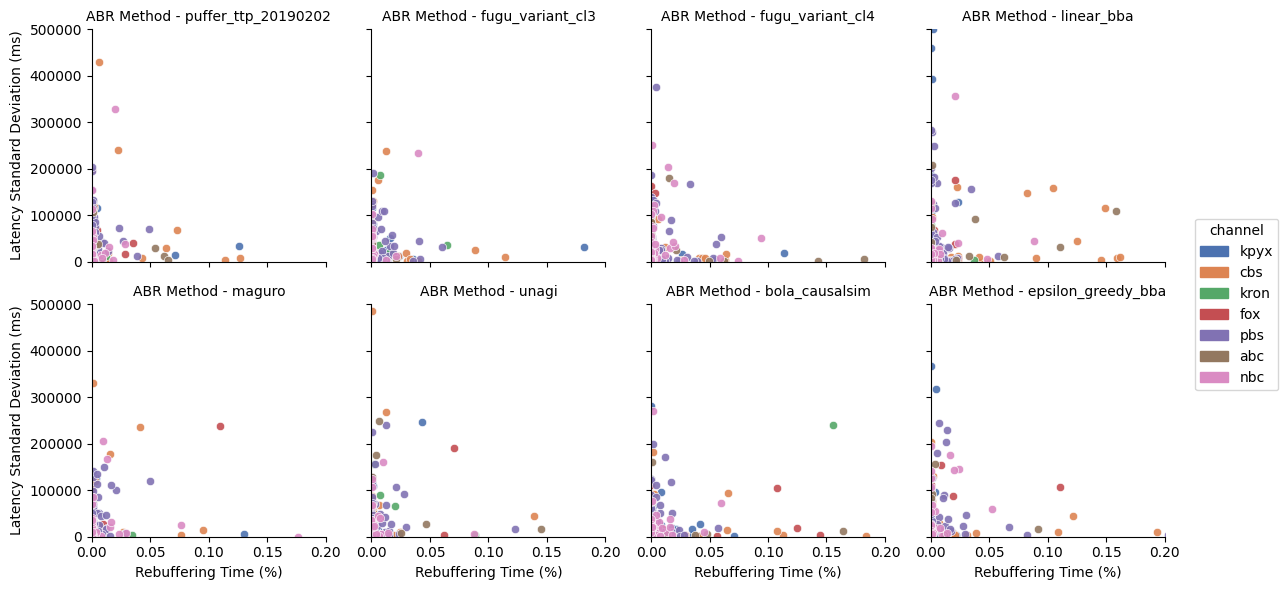

In [41]:
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2),ylim=(0,500000))
#grid.add_legend()
grid.set_titles("ABR Method - {col_name}")
grid.map(sns.scatterplot,"rebuf","std_latency",alpha=0.9)
grid.set_axis_labels(x_var="Rebuffering Time (%)", y_var="Latency Standard Deviation (ms)")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

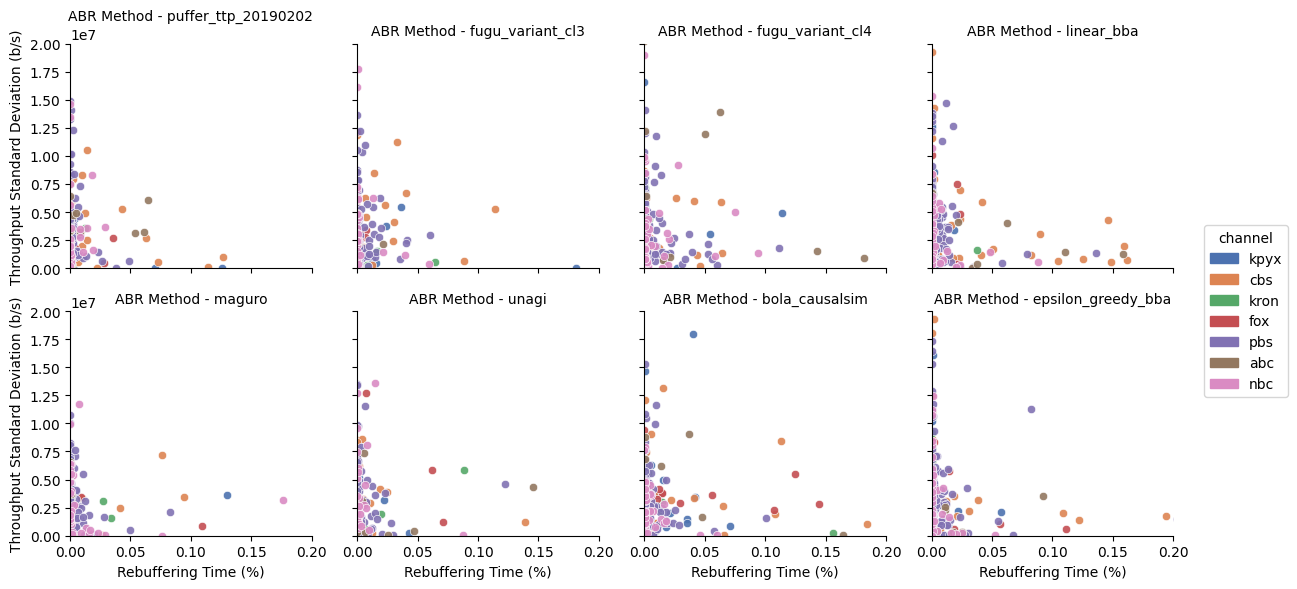

In [42]:
hue_order = graph_df["channel"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="channel", hue_order=hue_order, palette="deep", col_wrap=4,xlim=(0,0.2),ylim=(0,20000000))
#grid.add_legend()
grid.set_titles("ABR Method - {col_name}")
grid.map(sns.scatterplot,"rebuf","std_throughput",alpha=0.9)
grid.set_axis_labels(x_var="Rebuffering Time (%)", y_var="Throughput Standard Deviation (b/s)")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='channel', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

Below we compare the performance of various algorithms under different network conditions. A strong algorithm should perform well in low throughput and high latency settings.

For these plots, we define low, medium, and high not by an arbitrary fixed value, but from the observed network conditions in the data. "Low" corresponds to the lowest 1/3rd of values -- e.g. the 0th through 33rd percentiles. Medium and high are likewise defined using the middle and top tri-tiles.

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


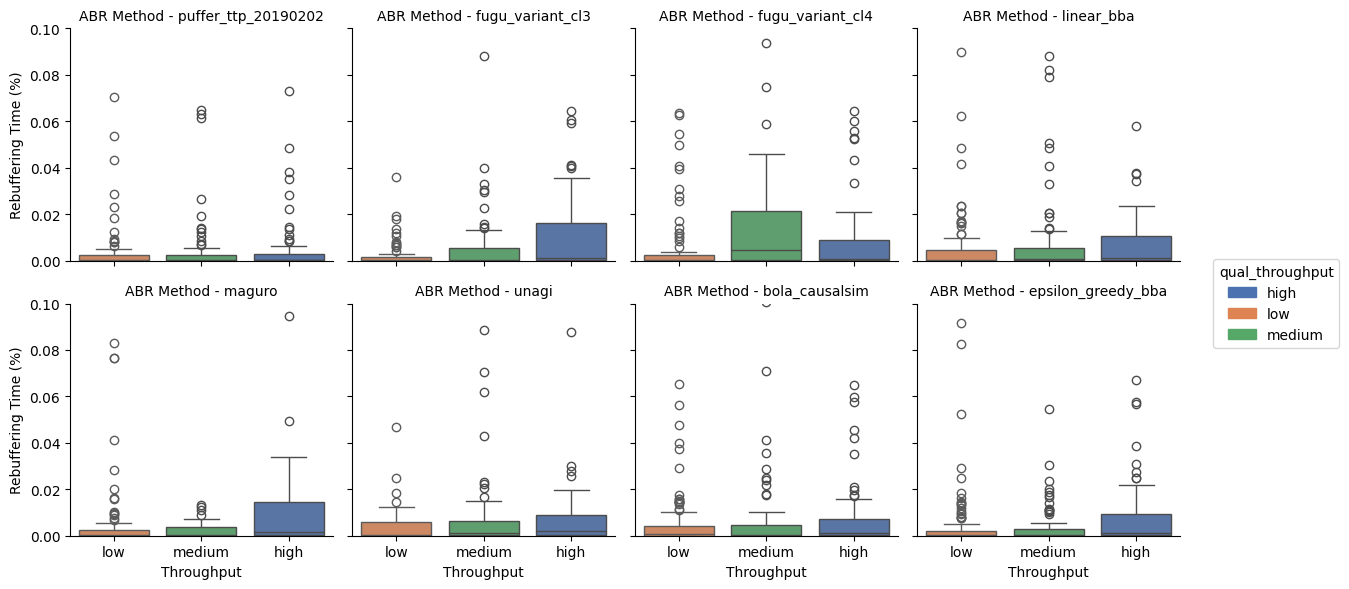

In [44]:
hue_order = graph_df["qual_throughput"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="qual_throughput", hue_order=hue_order, palette="deep", col_wrap=4,ylim=(0,0.1))
#grid.add_legend()
grid.set_titles("ABR Method - {col_name}")
grid.map(sns.boxplot,"qual_throughput","rebuf")
grid.set_axis_labels(y_var="Rebuffering Time (%)", x_var="Throughput")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

/Users/parkercarlson/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


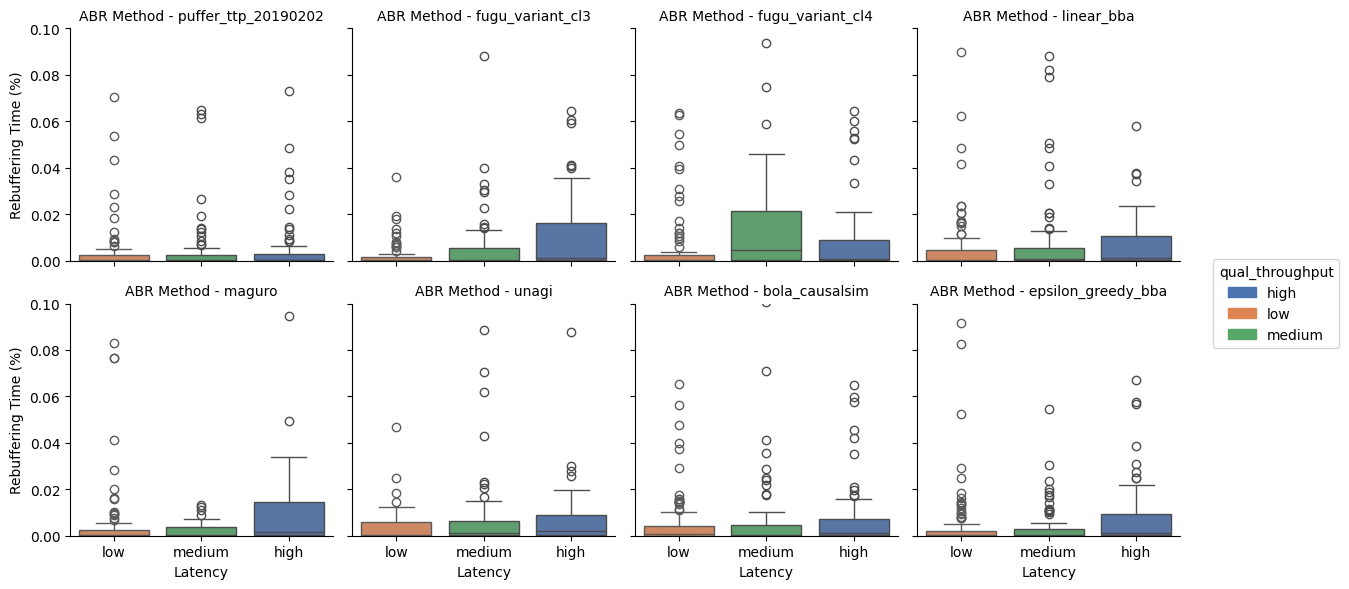

In [45]:
hue_order = graph_df["qual_latency"].unique()[::-1]

grid = sns.FacetGrid(graph_df, col="expt_id", hue="qual_latency", hue_order=hue_order, palette="deep", col_wrap=4,ylim=(0,0.1))
#grid.add_legend()
grid.set_titles("ABR Method - {col_name}")
grid.map(sns.boxplot,"qual_latency","rebuf")
grid.set_axis_labels(y_var="Rebuffering Time (%)", x_var="Latency")


# seaborn legend is broken and doesn't add colors
labels = hue_order
colors = sns.color_palette("deep").as_hex()[:len(labels)]
handles=[patches.Patch(color=col, label=lab) for col, lab in zip (colors, labels)]
plt.legend(handles=handles, title='qual_throughput', loc='center left', bbox_to_anchor=(1.1, 1))
plt.show()

# Apples-to-apples comparison in challenging network environments.

Now, we will directly compare two ABR algorithms on nearly-identical network conditions when streaming the same videos.

In [52]:
reader = OldReader("./data/fugu_bbr_exp/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)

    # rename ucsb columns to match order from stanford puffer
    df_sent = df_sent.rename(columns={"session_id": "channel",
                                     "channel": "session_id"})
    df_buf = df_buf.rename(columns={"session_id": "channel",
                                     "expt_id": "event",
                                     "channel": "expt_id",
                                     "event": "session_id"})
    
    

    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","index","channel"], how="left")
    group_df["expt_id"] = "fugu_bbr"
    return df_sent, df_acked, df_buf, group_df

df_sent, df_acked, df_buf, group_df = analyze(reader)

In [93]:
group_keys = ["expt_id", "session_id"]
group_df["delivery_rate"] = group_df["delivery_rate"].astype(np.float64)
group_df["rtt"] = group_df["rtt"].astype(np.float64)
group_df["qual_throughput"] = pd.qcut(group_df["delivery_rate"].astype(np.float64), 3, labels=["low","medium","high"])
grouped_group = group_df.groupby(group_keys)


time_s = (grouped_group["timestamp_x"].max() - grouped_group["timestamp_x"].min()).apply(lambda x: float(x) * 1000)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
fugu_graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                        })

In [86]:
reader = OldReader("./data/linear_bba_exp/")

def analyze(r):
    df_sent = pd.DataFrame(r.sent_chunks)
    df_acked = pd.DataFrame(r.acked_chunks)
    df_buf  = pd.DataFrame(r.buffer_level)


    for df, dtypes in [
        (df_sent, {"timestamp": int, "size": int, "video_ts": int}),
        (df_acked, {"timestamp": int, "video_ts": int}),
        (df_buf,  {"timestamp": int, "buffer": float, "cum_rebuf": float})]:
        for col, typ in dtypes.items():
            df[col] = df[col].astype(typ)

    for df in (df_sent, df_acked, df_buf):
        df["session_id"] = df["session_id"].astype(str)

    # rename ucsb columns to match order from stanford puffer
    df_sent = df_sent.rename(columns={"session_id": "channel",
                                     "channel": "session_id"})
    df_buf = df_buf.rename(columns={"session_id": "channel",
                                     "expt_id": "event",
                                     "channel": "expt_id",
                                     "event": "session_id"})
    
    

    group_df = df_sent.merge(df_buf, on=["expt_id","session_id","index","channel"], how="left")
    group_df["expt_id"] = "linear_bba"
    return df_sent, df_acked, df_buf, group_df

_,_,_, linear_group_df = analyze(reader)

In [94]:
group_keys = ["expt_id", "session_id"]
linear_group_df["delivery_rate"] = linear_group_df["delivery_rate"].astype(np.float64)
linear_group_df["rtt"] = linear_group_df["rtt"].astype(np.float64)
linear_group_df["qual_throughput"] = pd.qcut(linear_group_df["delivery_rate"].astype(np.float64), 3, labels=["low","medium","high"])
grouped_group = linear_group_df.groupby(group_keys)


#time_s = (grouped_group["timestamp_x"].max() - grouped_group["timestamp_x"].min()).apply(lambda x: float(x) / 1000000000.0)
time_s = (grouped_group["timestamp_x"].max() - grouped_group["timestamp_x"].min()).apply(lambda x: float(x) * 1000)
norm_rebuf = grouped_group["cum_rebuf"].max() / time_s
norm_rebuf = norm_rebuf.dropna()
linear_graph_df = pd.DataFrame({"rebuf": norm_rebuf,
                         "channel": grouped_group["channel"].max(),
                         "avg_buffer": grouped_group["buffer"].mean(),
                         "std_throughput": grouped_group["delivery_rate"].std(),
                         "std_latency": grouped_group["rtt"].std(),
                         "qual_throughput": grouped_group["qual_throughput"].min(),
                        })

In [95]:
combo_df = pd.concat([linear_graph_df,fugu_graph_df])

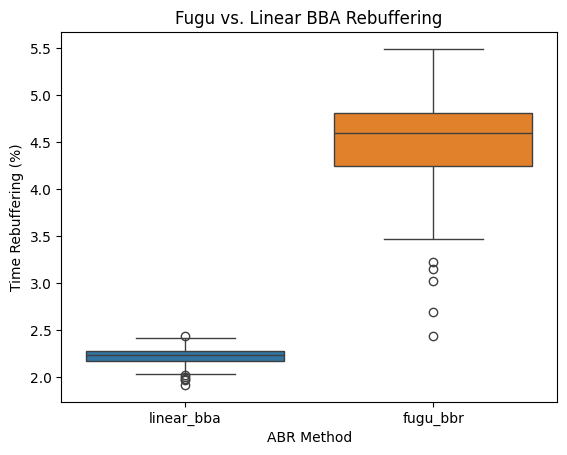

In [98]:
ax = sns.boxplot(combo_df,x="expt_id",y="rebuf",hue="expt_id")
ax.set_xlabel("ABR Method")
ax.set_ylabel("Time Rebuffering (%)")
plt.title("Fugu vs. Linear BBA Rebuffering")
plt.show()

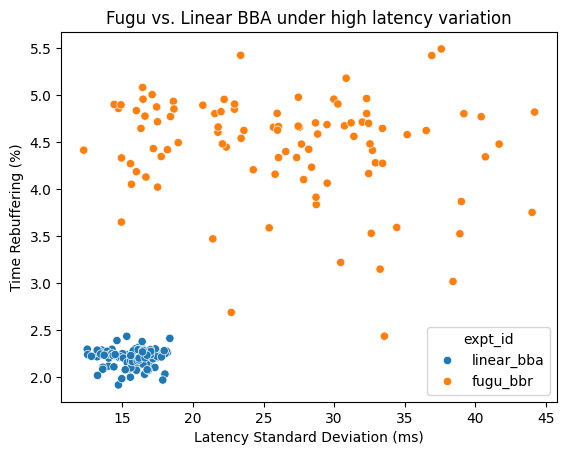

In [101]:
ax =sns.scatterplot(combo_df,x="std_latency",y="rebuf",hue="expt_id")
ax.set_xlabel("Latency Standard Deviation (ms)")
ax.set_ylabel("Time Rebuffering (%)")
plt.title("Fugu vs. Linear BBA under high latency variation")
plt.show()

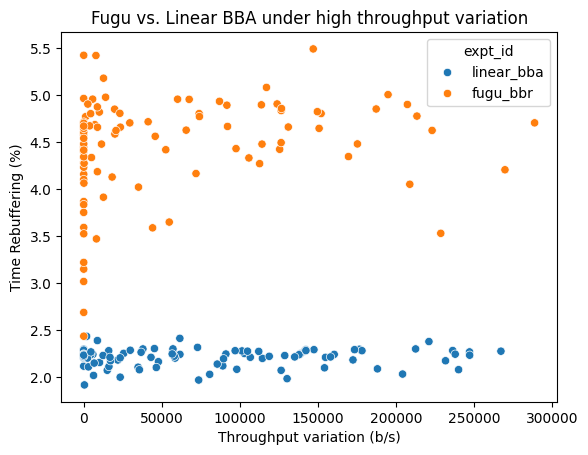

In [102]:
ax = sns.scatterplot(combo_df,x="std_throughput",y="rebuf",hue="expt_id")
ax.set_xlabel("Throughput variation (b/s)")
ax.set_ylabel("Time Rebuffering (%)")
plt.title("Fugu vs. Linear BBA under high throughput variation")
plt.show()